In [3]:
%matplotlib inline
import utils
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import vonmises

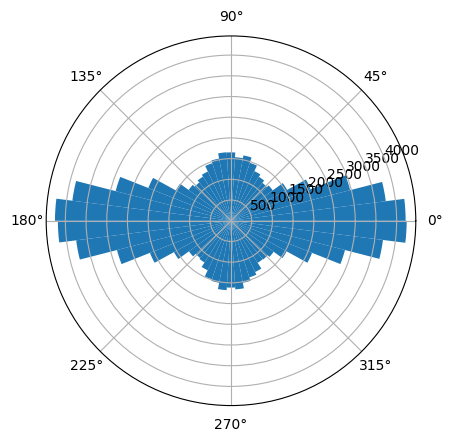

In [4]:
fs = 240.
ppd = 240.
D = 20.
a = int((0.15 + np.random.random() * 0.15) * fs)

drift_pre = np.astype(utils.brownian_eye_trace(D, fs, 32) / 60 * ppd, np.int64)
saccade = np.astype(utils.generate_saccade(10., np.pi/2., fs) * ppd, np.int64)
drift_post = np.astype(utils.brownian_eye_trace(D, fs, a) / 60 * ppd, np.int64)

trace = np.concat((drift_pre.T, saccade.T + drift_pre[:,-1]))
trace = np.concat((trace, drift_post.T + trace[-1, :]))

theta = np.zeros(100000)
for i in range(theta.size):
    match np.random.randint(4):
        case 0:
            center = 0
            kappa = 10
        case 1:
            center = np.pi
            kappa = 10
        case 2:
            center = np.pi / 2.
            kappa = 2
        case 3:
            center = -np.pi / 2.
            kappa = 2

    theta[i] = vonmises.rvs(loc=center, kappa=kappa)

plt.figure()
# plt.plot(trace)
ax = plt.subplot(projection='polar')
ax.hist(theta, bins=50)
plt.show()




[0. 0.]


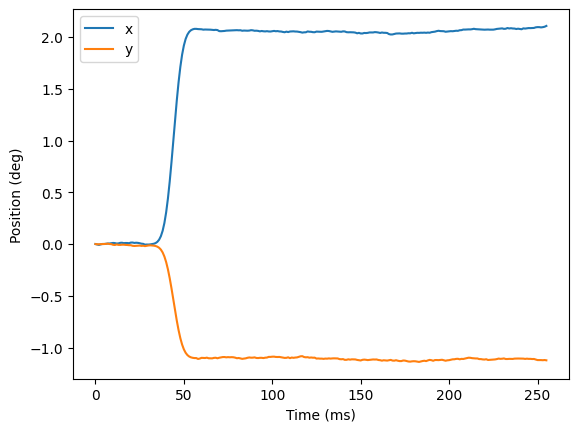

In [5]:
em, amp, dir = utils.gen_em_sequence(32, 1000, 20)
print(em[0,:])

plt.figure()
plt.plot(em)
plt.xlabel("Time (ms)")
plt.ylabel("Position (deg)")
plt.legend(["x", "y"])
plt.show()

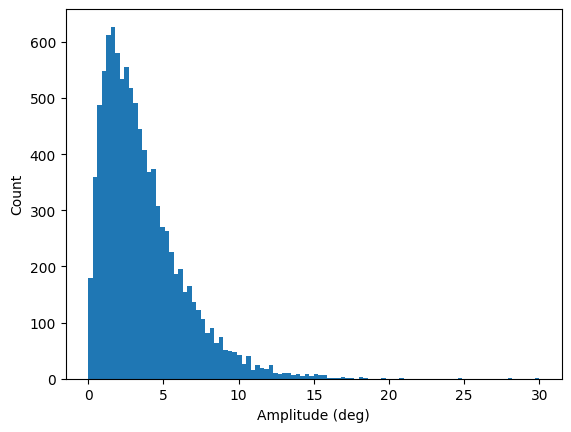

In [6]:

a = np.random.gamma(1.8, 2, 10000)
plt.figure()
plt.hist(a.T, bins=100)
plt.ylabel("Count")
plt.xlabel("Amplitude (deg)")
plt.show()


tensor(0)


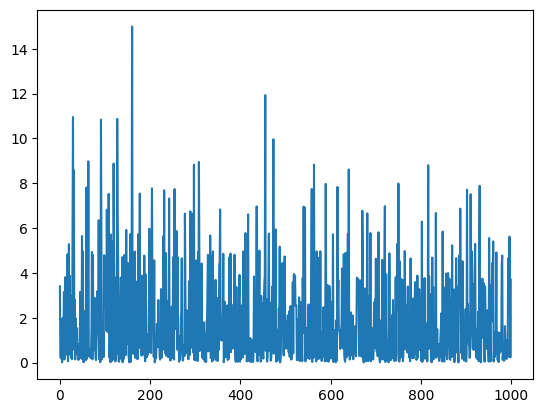

In [7]:
import torch

a = torch.rand(1000).float()
a += torch.poisson(a)
print(torch.sum(a < 0))

plt.figure()
plt.plot(a + torch.poisson(a));
plt.show()

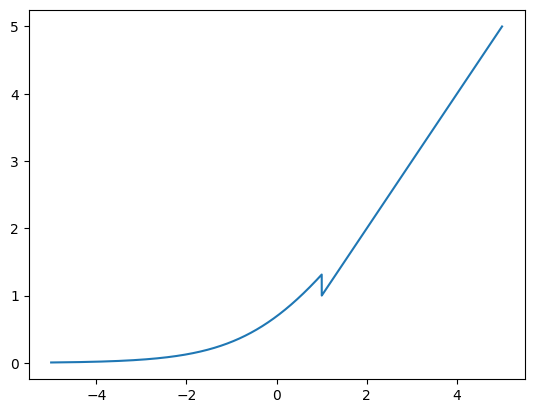

In [14]:

import torch 
t = torch.arange(-5, 5, 0.001)
x = torch.nn.functional.softplus(t, 1., 1.)

plt.figure()
plt.plot(t, x)
plt.show()